<a href="https://colab.research.google.com/github/amukherjea/amukherjea.github.io/blob/master/HW2p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
#upload kaggle.json here
files.upload()
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!ls #check if kaggle.json is uploaded
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle/’: File exists
kaggle.json  sample_data


In [5]:
!kaggle datasets download -d cmu11785/20fall-hw2p2

 99% 1.34G/1.35G [00:22<00:00, 112MB/s]
100% 1.35G/1.35G [00:22<00:00, 65.0MB/s]


In [10]:
!unzip '*.zip'

Streaming output truncated to the last 5000 lines.
  inflating: verification_data/00064100.jpg  
  inflating: verification_data/00064101.jpg  
  inflating: verification_data/00064102.jpg  
  inflating: verification_data/00064103.jpg  
  inflating: verification_data/00064104.jpg  
  inflating: verification_data/00064105.jpg  
  inflating: verification_data/00064106.jpg  
  inflating: verification_data/00064107.jpg  
  inflating: verification_data/00064108.jpg  
  inflating: verification_data/00064109.jpg  
  inflating: verification_data/00064110.jpg  
  inflating: verification_data/00064111.jpg  
  inflating: verification_data/00064112.jpg  
  inflating: verification_data/00064113.jpg  
  inflating: verification_data/00064114.jpg  
  inflating: verification_data/00064115.jpg  
  inflating: verification_data/00064116.jpg  
  inflating: verification_data/00064117.jpg  
  inflating: verification_data/00064118.jpg  
  inflating: verification_data/00064119.jpg  
  inflating: verification_dat

In [20]:
#!ls classification_data/train_data/n000003/
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from collections import namedtuple
from IPython.display import Image
%matplotlib inline
np.random.seed(2020)



from pathlib import Path
from PIL import Image
import os, shutil
from os import listdir
## Image Resizing
from PIL import Image

# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
import time

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
X_image_train = []
images_dir = 'classification_data/train_data/n000003/'
for fname in listdir(images_dir):
    fpath = os.path.join(images_dir, fname)
    im = Image.open(fpath)
    X_image=np.array(im,dtype='uint8')
    X_image_train.append(X_image)

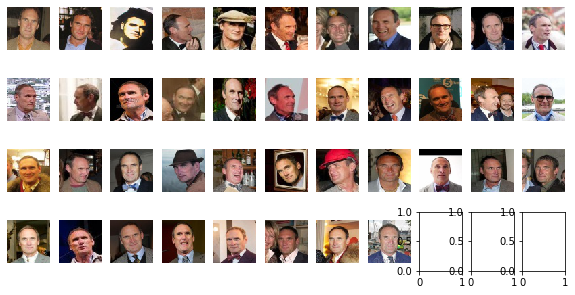

In [ ]:
f, a = plt.subplots(4, 11, figsize=(10, 5))
for i in range(len(X_image_train)):
    X = X_image_train[i]
    r, c = i // 11, i % 11
    #a[r][c].set_title(Y)
    a[r][c].axis('off')
    a[r][c].imshow(X)
plt.draw()

In [18]:
batch_size = 256
num_workers = 8 if cuda else 0 

images_dir_train = 'classification_data/train_data'
images_dir_val = 'classification_data/val_data'
images_dir_test = 'classification_data/test_data'

data_transform = transforms.Compose([
        #transforms.RandomResizedCrop(100),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

train_data = datasets.ImageFolder(images_dir_train, transform=data_transform, target_transform=None,is_valid_file=None)
val_data = datasets.ImageFolder(images_dir_val, transform=None, target_transform=None,is_valid_file=None)
test_data = datasets.ImageFolder(images_dir_test, transform=None, target_transform=None,is_valid_file=None)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=256, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=256, shuffle=True, num_workers=num_workers)

In [ ]:
len(test_data)

8000

In [ ]:
count = 0
y_max = -1
for x,y in train_loader:
     x = x.numpy()
     #print(x.shape)
     for img, label in zip(x,y):
            y_max = np.maximum(y_max,label)
#         print("Label: {}".format(label))
#         plt.imshow(img.transpose((1,2,0)))
#         plt.show() 
print(y_max)

tensor(3999)


In [24]:
class BasicCNNModule(nn.Module):
    def __init__(self):
        super(BasicCNNModule, self).__init__()
        self.conv1 = nn.Conv2d(3,64,kernel_size = 3, stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm2d((3,64))
        self.dropout = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d((64,64))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64,128,kernel_size = 3, stride = 1, padding = 1)
        self.bn3 = nn.BatchNorm2d((64,128))
        self.conv4 = nn.Conv2d(128,128,kernel_size = 3, stride = 1, padding = 1)
        self.bn4 = nn.BatchNorm2d((128,128))
        self.conv5 = nn.Conv2d(128,256,kernel_size = 3, stride = 1, padding = 1)
        self.bn5 = nn.BatchNorm2d((128,256))
        self.conv6 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 1)
        self.bn6 = nn.BatchNorm2d((256,256))
        self.fc1 = nn.Linear(256, 4000)
        self.ReLu = nn.ReLU()
        #self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 10)
        # self.shortcut = None #use it for skip connections

    def forward(self, x):
        x = self.dropout(self.ReLu(self.bn1(self.conv1(x)))) #Layer 1
        x = self.pool(self.ReLu(self.bn2(self.conv2(x)))) #Layer 2
        x = self.pool(self.Relu(self.bn2(self.conv2(x)))) #Layer 3
        x = self.dropout(self.Relu(self.bn3(self.conv3(x)))) #Layer 4
        x = self.pool(self.Relu(self.bn4(self.conv4(x)))) #Layer 5
        x = self.dropout(self.Relu(self.bn5(self.conv5(x)))) #Layer 6
        x = self.pool(self.Relu(self.bn6(self.conv6(x)))) #Layer 7
        x = self.pool(self.Relu(self.bn6(self.conv6(x)))) #Layer 8
        x = self.pool(self.Relu(self.bn6(self.conv6(x)))) #Layer 9
        x = self.pool(self.Relu(self.conv2(x)))
        #x = x.view(-1, 16 * 5 * 5)
        x = Relu(self.fc1(x))
        #x = Relu(self.fc2(x))
        # if self.shortcut: #case of skip conenction
        #  x = self.shortcut(x) 
        #x = self.fc3(x)
        return x
        
print(BasicCNNModule())
model = BasicCNNModule()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.15, momentum=0.9, weight_decay = 5e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.85, step_size=200)
device = torch.device("cuda" if cuda else "cpu")
model.to(device)
print(model)

BasicCNNModule(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d((3, 64), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d((64, 64), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d((64, 128), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d((128, 128), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d((128, 256), eps=1e-05, momentum=0.1, affine=True, track_running_

In [15]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict' : scheduler.state_dict(),
        }, "gdrive/My Drive/hw2/"+"Model_"+str(epoch))
    return running_loss

In [16]:
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(test_loader):   
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc

In [25]:
n_epochs = 10
Train_loss = []
Test_loss = []
Test_acc = []

for i in range(n_epochs):
  
    train_loss = train_epoch(model, train_loader, optimizer,criterion)
    test_loss, test_acc = test_model(model, val_loader, criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    print('='*20)

RuntimeError: ignored